# Muon flux estimation

This script estimate the muon flux depending on the global coordinates (Latitude, Longitude and Altitude) of the observation point.

"two codes called Corsika and DistanceCode were used, with these the parameters that MUSIC required to develop
the calculation were complemented; Corsika delivered initial angles (zenith and azimuth) and initial energy, and DistanceCode completed these data with the distance traveled by the muons when crossing the volcano and their Cartesian coordinates, taking into account the muon's telescope position."

Lina Girón Master thesis, 2021

In [4]:
Image(url= "figures/MUSIC.png", width=400, height=200)

Data flux of the simulation chain reported by Lina Giron

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.optimize import curve_fit
from mpl_toolkits import mplot3d
import pyproj
import sys

## Gaisser Model (1990)

Gaisser gives a standar parameterization model of the atmospheric muon flux (Gaisser et al., 1990):

$$\Phi_G( E_{0}, \theta) = A_G E_0^{-\gamma} \left( \frac{1}{1+\frac{\hat{E}_{0} \cos \theta}{E^{cr}_{0,\pi}}} + \frac{B_G}{1+\frac{\hat{E}_{0} \cos \theta}{E^{cr}_{0,k}}} + r_c \right) [cm^{-2}sr^{-1}s^{-1}GeV^{-1}]$$

where the adjustable parameters are the scale factor $A_G$, the power index $\gamma$ , the balance factor $B_G$ , which depends on the ratio of muons produced by the kaons and the pions, and the ratio $r_c$ of the prompt
muons to pions. $\hat{E}_0$ represents the energy of muons on top of the atmosphere; $E_0$ is
the muon energy at sea level, $E_0 \approx \hat{E}_0$. The cr energies $E^{cr}_{0,π}$ and $E^{cr}_{0,K}$ may be interpreted as critical energies of pions and kaons for the vertical incidence (i.e. $\theta = 0$). These physical quantities should be non-adjustable parameters and should be determined through quantum mechanical calculus. However, most authors consider $E_{0,π}$ and $E_{0,K}$ as adjustable parameters when fitting model (2) to data sets. Table 2 recalls the best estimates of these parameters published by several authors.

Lesparre, 2010

In [2]:
from IPython.display import Image
Image(url= "figures/Model_Parameters.png", width=800, height=400)

In [5]:
def muon_flux_Gaisser(AG,BG,gamma,Epion,Ekaon,rc, theta, Eu):
    flux = AG*(Eu**(-gamma))*(1/(1+Eu*np.cos(theta)/Epion) + BG/(1+Eu*np.cos(theta)/Ekaon) + rc)
    return flux

In [18]:
# Gaisser model parameters

AG = 0.14
BG = 0.054
gamma = 2.7
Epion = 115/1.1
Ekaon = 850/1.1
rc = 0

In [53]:
cenith = 45
theta = cenith*np.pi/180.0 # cenith angle / redians
Eu = np.linspace(10,1e4,10000) # Muon energy / GeV

Phi_Gaisser = muon_flux_Gaisser(AG,BG,gamma,Epion,Ekaon,rc, theta, Eu)

Model performance is evaluated with results of the paper:
Ning Su. A Comparison of Muon Flux Models at Sea Level for Muon Imaging and Low Background Experiments. Frontiers in energy research. 2021.

Lesparre.Geophysical muon imaging: Feasibility and limits. 2010

Revisar Hebbeker&Timmermans (2002)

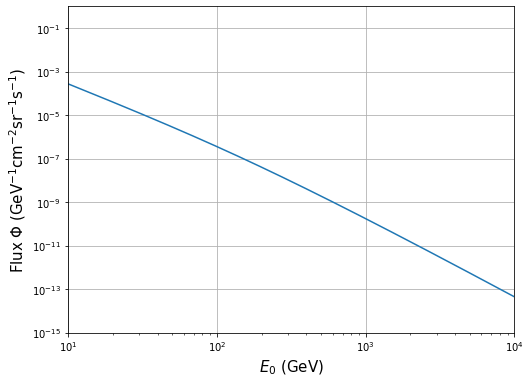

In [54]:
plt.figure(figsize=(8,6))
plt.loglog(Eu,Phi_Gaisser)
plt.xlabel("$E_0$ (GeV)", fontsize = 15)
plt.ylabel("Flux $\Phi$ (GeV$^{-1}$cm$^{-2}$sr$^{-1}$s$^{-1}$)", fontsize = 15)
plt.axis([10,1e4,1e-15,1e0])
plt.grid()

## Gaisser-Tang Model

(Lesparre)

The empirical spectrum model given by eq. (2) strongly overestimates the incident flux for $E_0 < 100/\cos \theta GeV$ and Tang et al. (2006) proposed a modified version of the original Gaisser’s model. A version of this modified spectrum is used in the MUSIC Monte Carlo simulation code (Kudryavtsev 2009) with $r_c = 10^{−4}$ and

$$\cos \theta^* = \sqrt{ 1 - \frac{1 -\cos^2 \theta}{(1 + H_{atm}/R_{Earth})^2}}$$

where $R_{Earth}$ = 6370 km is the Earth radius and $H_{atm}$ = 32 km is the altitude of production for muons with a trajectory at large angles.

$$\hat{E}_0 = E_0 + \Delta E_0$$

where

$$\Delta E_0 = 0.00206 \left( \frac{1030}{\cos \theta^*} - 120 \right)$$

$$AT = AG \left( \frac{120\cos \theta^*}{1030} \right)^{\frac{1.04}{(E_0+\Delta E_0/2)\cos \theta^*}}$$

In [55]:
def muon_flux_Tang(AG,BG,gamma,Epion,Ekaon,rc, theta, Eu):
    
    cosTheta = np.sqrt(1-(1-((np.cos(theta))**2))/(1+Hatm/REarth)**2)
    DeltaE0 = 0.00206*(1030.0/cosTheta -120)
    E0 = Eu + DeltaE0
    AT = AG*(120*cosTheta/1030.0)**(1.04/((Eu + DeltaE0/2)*cosTheta))

    flux = AT*(E0**(-gamma))*(1/(1+E0*cosTheta/Epion) + BG/(1+E0*cosTheta/Ekaon) + rc)
    return flux

In [56]:
REarth = 6370.0 # km
Hatm = 32.0 # km
rc = 1e-4

Phi_Tang = muon_flux_Tang(AG,BG,gamma,Epion,Ekaon,rc, theta, Eu)

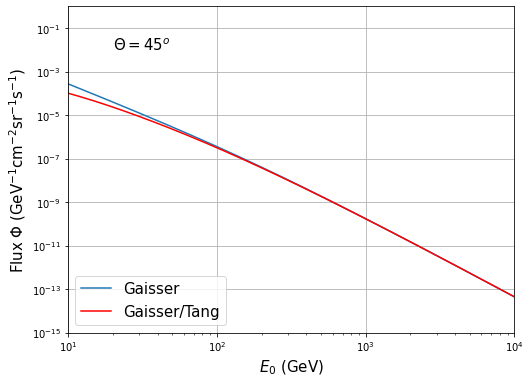

In [57]:
plt.figure(figsize=(8,6))
plt.loglog(Eu,Phi_Gaisser, label='Gaisser')
plt.loglog(Eu,Phi_Tang, 'r', label='Gaisser/Tang')
plt.xlabel("$E_0$ (GeV)", fontsize = 15)
plt.ylabel("Flux $\Phi$ (GeV$^{-1}$cm$^{-2}$sr$^{-1}$s$^{-1}$)", fontsize = 15)
plt.axis([10,1e4,1e-15,1e0])
plt.legend(loc=3, fontsize = 15)
plt.text(2e1,1e-2,'$\Theta =$' + str(cenith) + '$^o$', fontsize = 15)
plt.grid()

(Lechmann)

However, because the agreement between model and measurements worsens especially in the low energy region,
several modifications as well as other model parametrisations have been proposed. In this context, Tang et al. (2006) introduced a slight modification of the “Gaisser equation” (A2), to account for this issue:

$$\cos \theta^* = \sqrt{ \frac{x^2  + p^2_1 + p_2x^{p_3} + p_4x^{p_5}}{1 + p^2_1 + p_2 + p_4}}$$

where $x = \cos \theta$, $p_1 = 0.102573$, $p_2=-0.068287$, $p_3 = 0.958633$, $p_4=0.0407253$ ,and $p_5=0.817285$.
$$\hat{E}_0 = E_0 + \Delta$$

where

$$\Delta = 0.00206 \left( \frac{950}{\cos \theta^*} - 90 \right)$$

$$A = 1.1 \left( \frac{90 \sqrt{\cos \theta + 0.001}}{1030} \right)^ {\frac{4.5}{E_0 \cos \theta^*}}$$

In [58]:
def muon_flux_Tang_Lechmann(AG,BG,gamma,Epion,Ekaon,rc, theta, Eu):
    
    x = np.cos(theta)
    p1 = 0.102573
    p2 = -0.068287
    p3 = 0.958633
    p4 = 0.0407253
    p5 = 0.817285
    
    
    cosTheta = np.sqrt((x**2 + p1**2 +p2*x**p3+p4*x**p5)/(1+p1**2+p2+p4))
    E = (3*Eu + 7/cosTheta)/10.0
    
    DeltaE0 = 0.00206*(950.0/cosTheta -90)
    E0 = Eu + DeltaE0
    
    A = 1.1*(90*np.sqrt(x + 0.001)/1030.0)**(4.5/(Eu *cosTheta))

    flux = A*AG*(E**(-gamma))*(1/(1+E0*cosTheta/Epion) + BG/(1+E0*cosTheta/Ekaon) + rc)
    return flux

In [59]:
Phi_Tang_Lechmann = muon_flux_Tang_Lechmann(AG,BG,gamma,Epion,Ekaon,rc, theta, Eu)

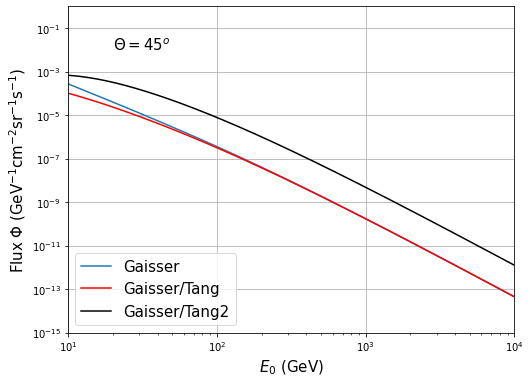

In [60]:
plt.figure(figsize=(8,6))
plt.loglog(Eu,Phi_Gaisser, label='Gaisser')
plt.loglog(Eu,Phi_Tang, 'r', label='Gaisser/Tang')
plt.loglog(Eu,Phi_Tang_Lechmann, 'k', label='Gaisser/Tang2')
plt.xlabel("$E_0$ (GeV)", fontsize = 15)
plt.ylabel("Flux $\Phi$ (GeV$^{-1}$cm$^{-2}$sr$^{-1}$s$^{-1}$)", fontsize = 15)
plt.axis([10,1e4,1e-15,1e0])
plt.legend(loc=3, fontsize = 15)
plt.text(2e1,1e-2,'$\Theta =$' + str(cenith) + '$^o$', fontsize = 15)
plt.grid()

## Bugaev-Reina Model

In addition to the energy loss of the muons produced by the two-body decay of pions and kaons, the muons produced by the three-body decay of kaons were also considered. Since the model aims to describe only the vertical differential flux of muons, the atmospheric curvature has no effect on the transport of muons and can be excluded. The model is expressed in the form of a fitting formula (Bugaev et al., 1998).

$$\Phi_B(p) = A_B p^{-(a_3y^3+a_2y^2+a_1y+a_0)}$$

where p is the muon momentum at sea level, and $y = \log p$; $A_B$ , $a_0$ , $a_1$ , $a_2$ , and $a_3$ are fitting parameters. The parameter values are adjusted with different momentum p ranges, as shown in

In [21]:
E0 = np.linspace(100e3,1e12,1000)
c = 3.0e8
m0 = 105.0e6/c**2

In [23]:
p = np.sqrt((E0**2-m0**2*c**4)/c**2)

/tmp/ipykernel_116234/1194067466.py:1: RuntimeWarning: invalid value encountered in sqrt
  p = np.sqrt((E0**2-m0**2*c**4)/c**2)


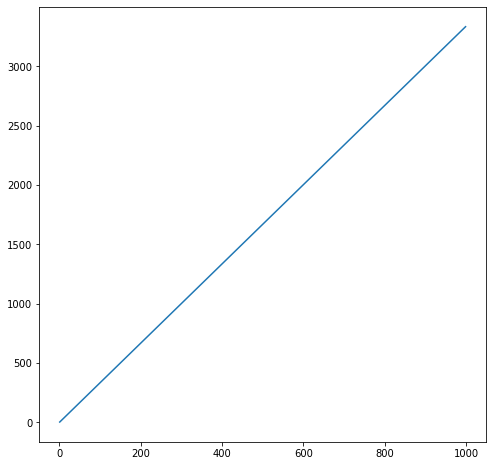

In [24]:
plt.figure(figsize=(8,8))
plt.plot(p)